In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("claims") \
    .getOrCreate()

In [3]:
%%time
df = spark.read.json("harvester/claims/aggregated.jsonl")

CPU times: user 2.54 ms, sys: 1.86 ms, total: 4.4 ms
Wall time: 2.27 s


In [4]:
!wc -l harvester/claims/aggregated.jsonl

6860 harvester/claims/aggregated.jsonl


In [5]:
df.count()

6860

In [6]:
df = df.where("version = '0.0.2'")
df.sort(F.col("scraped_at").desc()).show()

+------+-------------+--------------------+--------------------+--------------------+-------+
| claim|      crawler|          scraped_at|                 url|                uuid|version|
+------+-------------+--------------------+--------------------+--------------------+-------+
|  2207|ClaimsCrawler|2024-02-23 12:00:...|https://www.emple...|c750d89f-f301-403...|  0.0.2|
|   145|ClaimsCrawler|2024-02-23 12:00:...|https://hireline....|0a3f46a4-9ad9-440...|  0.0.2|
|138966|ClaimsCrawler|2024-02-23 12:00:...|https://www.occ.c...|4c021614-81e4-4ec...|  0.0.2|
|   192|ClaimsCrawler|2024-02-23 12:00:...|https://hireline....|470b0145-863a-4b6...|  0.0.2|
|  1130|ClaimsCrawler|2024-02-23 12:00:...|https://hireline....|c0f59909-d810-4a4...|  0.0.2|
| 14010|ClaimsCrawler|2024-02-23 12:00:...|https://talenteca...|b86a78d2-3153-4b4...|  0.0.2|
| 95270|ClaimsCrawler|2024-02-23 12:00:...|https://co.comput...|a8f17c3a-8080-4ea...|  0.0.2|
|129935|ClaimsCrawler|2024-02-23 12:00:...|https://mx.comput

In [7]:
df.select("url").distinct().collect()

[Row(url='https://talenteca.com/api/v1/job-ad/search'),
 Row(url='https://co.computrabajo.com'),
 Row(url='https://hireline.io/co/empleos'),
 Row(url='https://www.occ.com.mx/empleos/de--/'),
 Row(url='https://mx.computrabajo.com'),
 Row(url='https://hireline.io/mx/empleos'),
 Row(url='https://hireline.io/remoto/empleos'),
 Row(url='https://www.empleo.gob.mx/api/Login/homeSinSesion'),
 Row(url='https://www.empleonuevo.com/empleos')]

In [8]:
#        .sort("scraped_at")\
def get_ts_for_url(df, url, resample_by="D"):
    data = df.where(df.url.startswith(url))\
        .withColumn("num_claim", df["claim"].cast("int"))\
        .select("scraped_at", "num_claim").toPandas()
    data['scraped_at'] = pd.to_datetime(data['scraped_at'])
    data.set_index('scraped_at', inplace=True)
    if resample_by is not None:
        data = data.resample(resample_by).mean()
    return data

<Axes: xlabel='scraped_at'>

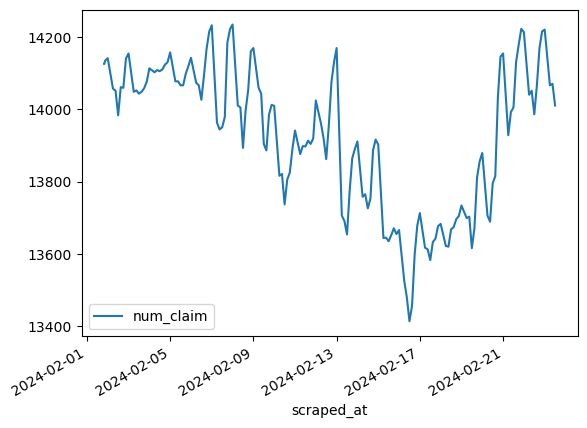

In [9]:
data = get_ts_for_url(df, "https://talenteca", resample_by=None)
data.plot()

count      154.000000
mean     13926.889610
std        198.660105
min      13414.000000
25%      13741.000000
50%      13970.500000
75%      14076.750000
max      14234.000000
Name: num_claim, dtype: float64


<Axes: >

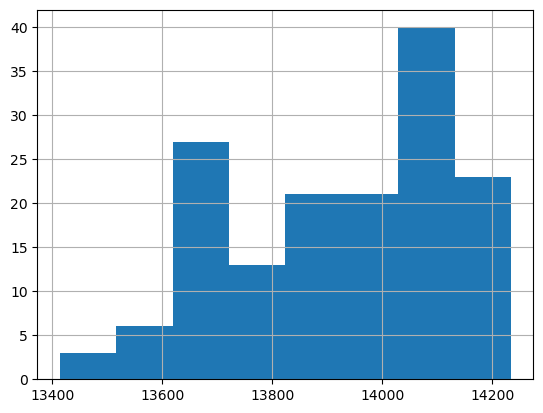

In [10]:
print(data.num_claim.describe())
data.num_claim.hist(bins=8)

<Figure size 1800x600 with 0 Axes>

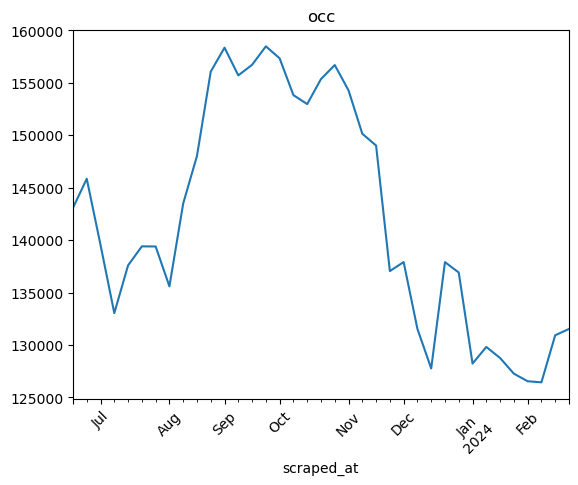

In [11]:
plt.figure(figsize=(18,6))
data = get_ts_for_url(df, "https://www.occ", resample_by="W")
data.plot(title="occ", legend=None)
_ = plt.xticks(rotation=45)

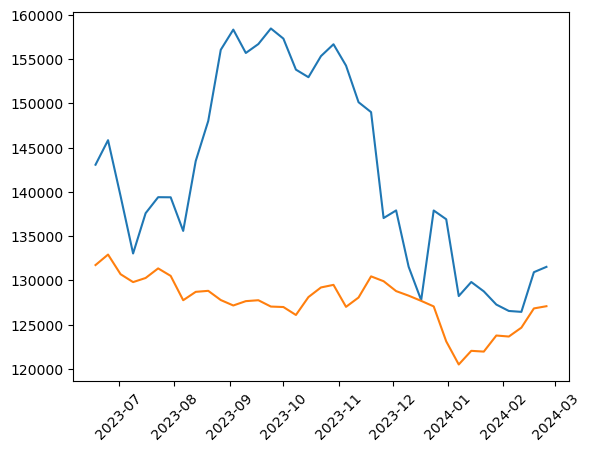

In [12]:
d1 = get_ts_for_url(df, "https://www.occ", resample_by="W")
plt.plot(d1)
d2 = get_ts_for_url(df, "https://mx.computrabajo", resample_by="W")
plt.plot(d2)
_ = plt.xticks(rotation=45)

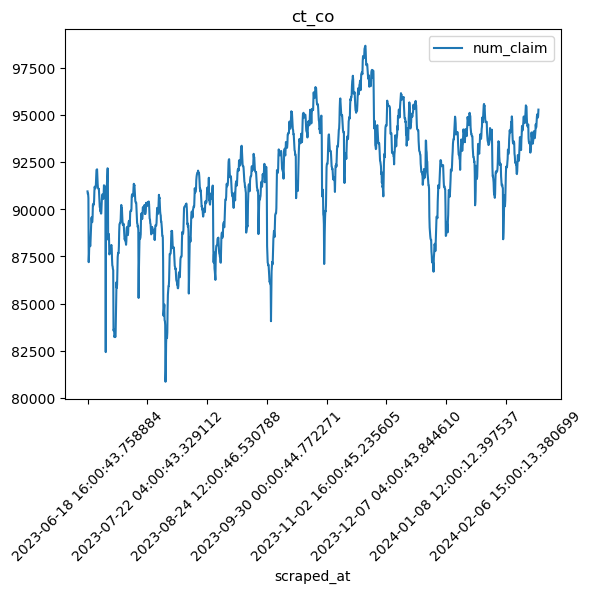

In [13]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

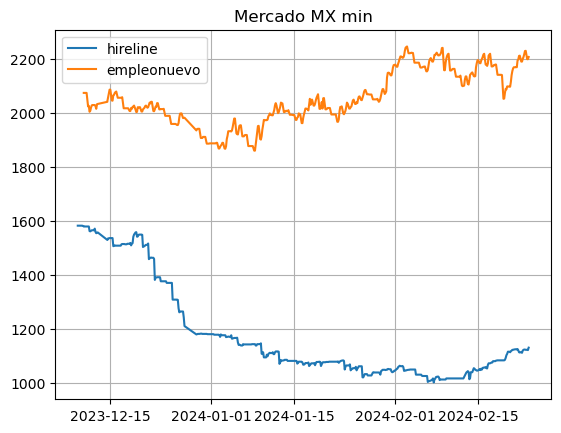

In [14]:
hl = df.where(df.url.startswith("https://hireline.io/mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
en = df.where(df.url.startswith("https://www.empleonuevo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl['scraped_at'] = pd.to_datetime(hl['scraped_at'])
en['scraped_at'] = pd.to_datetime(en['scraped_at'])
plt.grid(which="both")
plt.title("Mercado MX min")
_=plt.plot(hl.set_index('scraped_at'))
_=plt.plot(en.set_index('scraped_at'))
plt.legend(['hireline', 'empleonuevo'])


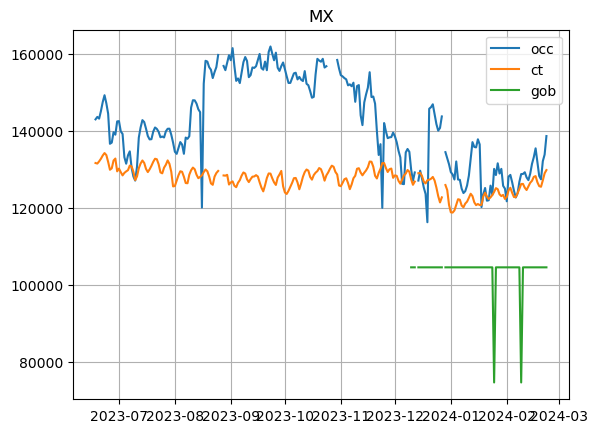

In [15]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
gob = df.where(df.url.startswith("https://www.empleo.gob.mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct['scraped_at'] = pd.to_datetime(ct['scraped_at'])
occ['scraped_at'] = pd.to_datetime(occ['scraped_at'])
gob['scraped_at'] = pd.to_datetime(gob['scraped_at'])

plt.plot(occ.set_index('scraped_at').resample('D').mean())
plt.plot(ct.set_index('scraped_at').resample('D').mean())
plt.plot(gob.set_index('scraped_at').resample('D').mean())
plt.grid(which="both")
plt.legend(['occ', 'ct', 'gob'])
plt.title("MX")
plt.show()

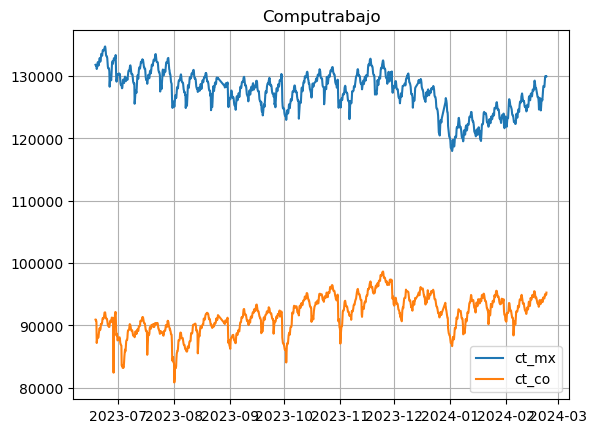

In [16]:
ct_mx = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
ct_co = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct_mx['scraped_at'] = pd.to_datetime(ct_mx['scraped_at'])
ct_co['scraped_at'] = pd.to_datetime(ct_co['scraped_at'])

plt.plot(ct_mx.set_index('scraped_at'))
plt.plot(ct_co.set_index('scraped_at'))
plt.grid(which="both")
plt.legend(["ct_mx", "ct_co"])
plt.title("Computrabajo")
plt.show()

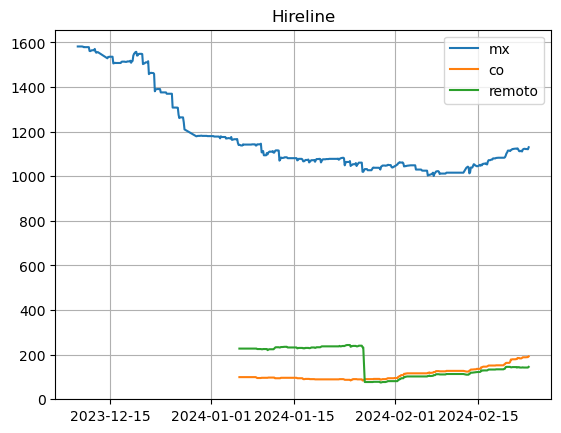

In [17]:
hl_mx = df.where(df.url.startswith("https://hireline.io/mx")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl_co = df.where(df.url.startswith("https://hireline.io/co")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
hl_re = df.where(df.url.startswith("https://hireline.io/re")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

hl_mx['scraped_at'] = pd.to_datetime(hl_mx['scraped_at'])
hl_co['scraped_at'] = pd.to_datetime(hl_co['scraped_at'])
hl_re['scraped_at'] = pd.to_datetime(hl_re['scraped_at'])

plt.plot(hl_mx.set_index('scraped_at'))
plt.plot(hl_co.set_index('scraped_at'))
plt.plot(hl_re.set_index('scraped_at'))
plt.grid(which="both")
plt.legend(["mx", "co", "remoto"])
plt.title("Hireline")
plt.show()